### Digital [Binary] Signal Detection

$\Large {\textrm{Tx: } \{p(a_n)\}: {\bm{a}} }\longrightarrow {\textrm{Cx: }y = {\bm{a}} +\eta :\mathcal{N}_{\eta}(0,\sigma_{\eta}) }\longrightarrow {\textrm{Rx: } }$

$\operatorname{M}({\bm{a}},\bm{\hat{a}})\Rightarrow\{p(y|a_n)\}$ -- metrics for comparison
$\bm{a} = \{a_n{\in }\mathbb{R}:n {\in} N\}$ -- Sets representing a finite number of indexed objects/states or relationships (symbols)

In [1]:
import numpy as np

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

from ipywidgets import interact
# data plotting
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams

rcParams['figure.figsize']     = [15,6]
rcParams['lines.markersize']   = 9
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['figure.dpi']     = 180

ModuleNotFoundError: No module named 'ipywidgets'

In [2]:
import os

def clearConsole():
    command = 'clear'
    if os.name in ('nt', 'dos'):  # If Machine is running on Windows, use cls
        command = 'cls'
    os.system(command)

In [3]:
def norMaxMin(signal):
    """
    Normalization of  a given array by scaling its values to a range of 0 to 1.
    """
    min_value = np.min(signal)
    max_value = np.max(signal)
    return (signal - min_value) / (max_value - min_value)

Histogram computation

In [4]:
def coloredhist(X,plot):
    """
    Creates a colored histogram based on the data distribution in X.
    Parameters:
    X (array-like): The data for which the histogram is to be plotted.
    plot (matplotlib axis object): The axis on which the histogram will be plotted.
    """
    Nbins = int(1 + 3.322*np.log2(len(X)))
    n, bins, patches = ax[1].hist(X, bins = Nbins, density=True)
    fracs = n / n.max()
    norm = colors.Normalize(fracs.min(), fracs.max())
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)
    plt.grid()
    return

**KDE Function**

In [5]:
def kde_function(signal_x,eval_points=None,method="Silverman",res=500):
    """
    Aplica el método de KDE gaussiano a la señal proporcionada y ajusta
    automáticamente el ancho de banda mediante una búsqueda en la cuadrícula.

    Parámetros:
    - signal: Señal a la que se aplica KDE.
    - eval_points: puntos de evaluación
    - method: método

    Retorna:
    - eval_points: Vector de evaluación.
    - y_sp: Función de densidad estimada en los puntos de evaluación.
    """
    if eval_points is None:
        eval_points = np.linspace(np.min(signal_x), np.max(signal_x),res)

    if method == 'Silverman':
        n = len(signal_x)
        sigma = np.std(signal_x)
        optimal_bandwidth = (4 / (3 * n)) ** (1 / 5) * sigma

        # print(f'Method:{method}\nOptimal bandwidth: {optimal_bandwidth:.2f}')
        kde = scipy.stats.gaussian_kde(signal_x, bw_method=optimal_bandwidth)
        y_sp = kde.pdf(eval_points)

    elif method == 'Cross Validation':
        # Define los posibles valores para el ancho de banda
        bandwidths = np.arange(0.05, 2, 0.05)

        # Crea y configura el objeto para la búsqueda en la cuadrícula
        kde = KernelDensity(kernel='gaussian')
        grid = GridSearchCV(kde, {'bandwidth': bandwidths})
        grid.fit(signal_x.reshape(-1, 1))
        # Obtiene el mejor estimador y su ancho de banda óptimo
        kde_optimal = grid.best_estimator_
        optimal_bandwidth = kde_optimal.bandwidth
        print(f'Optimal bandwidth: {optimal_bandwidth:.2f}')

        log_dens = kde_optimal.score_samples(eval_points.reshape(-1, 1))
        y_sp = np.exp(log_dens)

    else: return

    return (eval_points, y_sp)

#### Tx
message $x(\bm{a},t),\quad  \{p_i\in\mathbb{R}[0,1]\},\quad \sum_{\forall i}p_i = 1$

In [6]:
clearConsole()

def generate_symbols(Nsamples_por_symbol, symbol_values, symbol_probabilities, random_seed=None):
    """
    Genera una secuencia de símbolos aleatorios basada en probabilidades.

    Parámetros:
    - Nsymbols: Número de símbolos a generar.
    - symbol_values: Lista de valores posibles para los símbolos.
    - symbol_probabilities: Lista de probabilidades correspondientes a cada valor de símbolo.
    - random_seed: Semilla aleatoria para reproducibilidad.

    Retorna:
    - Una lista de símbolos generados.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    symbols = np.random.choice(symbol_values, size=Nsymbols, p=symbol_probabilities)
    return symbols

def generate_signal(symbols, Nsamples_por_symbol):
    """
    Genera la señal completa concatenando repeticiones de los símbolos.

    Parámetros:
    - symbols: Lista de símbolos a utilizar en la señal.
    - Nsamples_per_symbol: Número de muestras por símbolo.

    Retorna:
    - La señal completa generada.
    """
    signal = np.concatenate([[symbol] * Nsamples_por_symbol for symbol in symbols])
    return signal

In [7]:
# Parámetros para la generación de símbolos
Nsymbols = 128
Nsamples_por_symbol = 32
N = Nsymbols * Nsamples_por_symbol
symbol_values = [-1, 1]
symbol_probabilities = [0.5, 0.5]
random_seed = 42  # Puedes cambiar esto para obtener diferentes secuencias aleatorias.

# Genera símbolos y señal
symbols = generate_symbols(Nsymbols, symbol_values, symbol_probabilities, random_seed)
signal = generate_signal(symbols, Nsamples_por_symbol)

#### Cx
Channel simulation: Additive White Gaussian Noise: $\eta(t),$ with $\mathbb{E}\{\eta(t)\}=0$

(-3.2412673400690726, 3.9262377064363267)

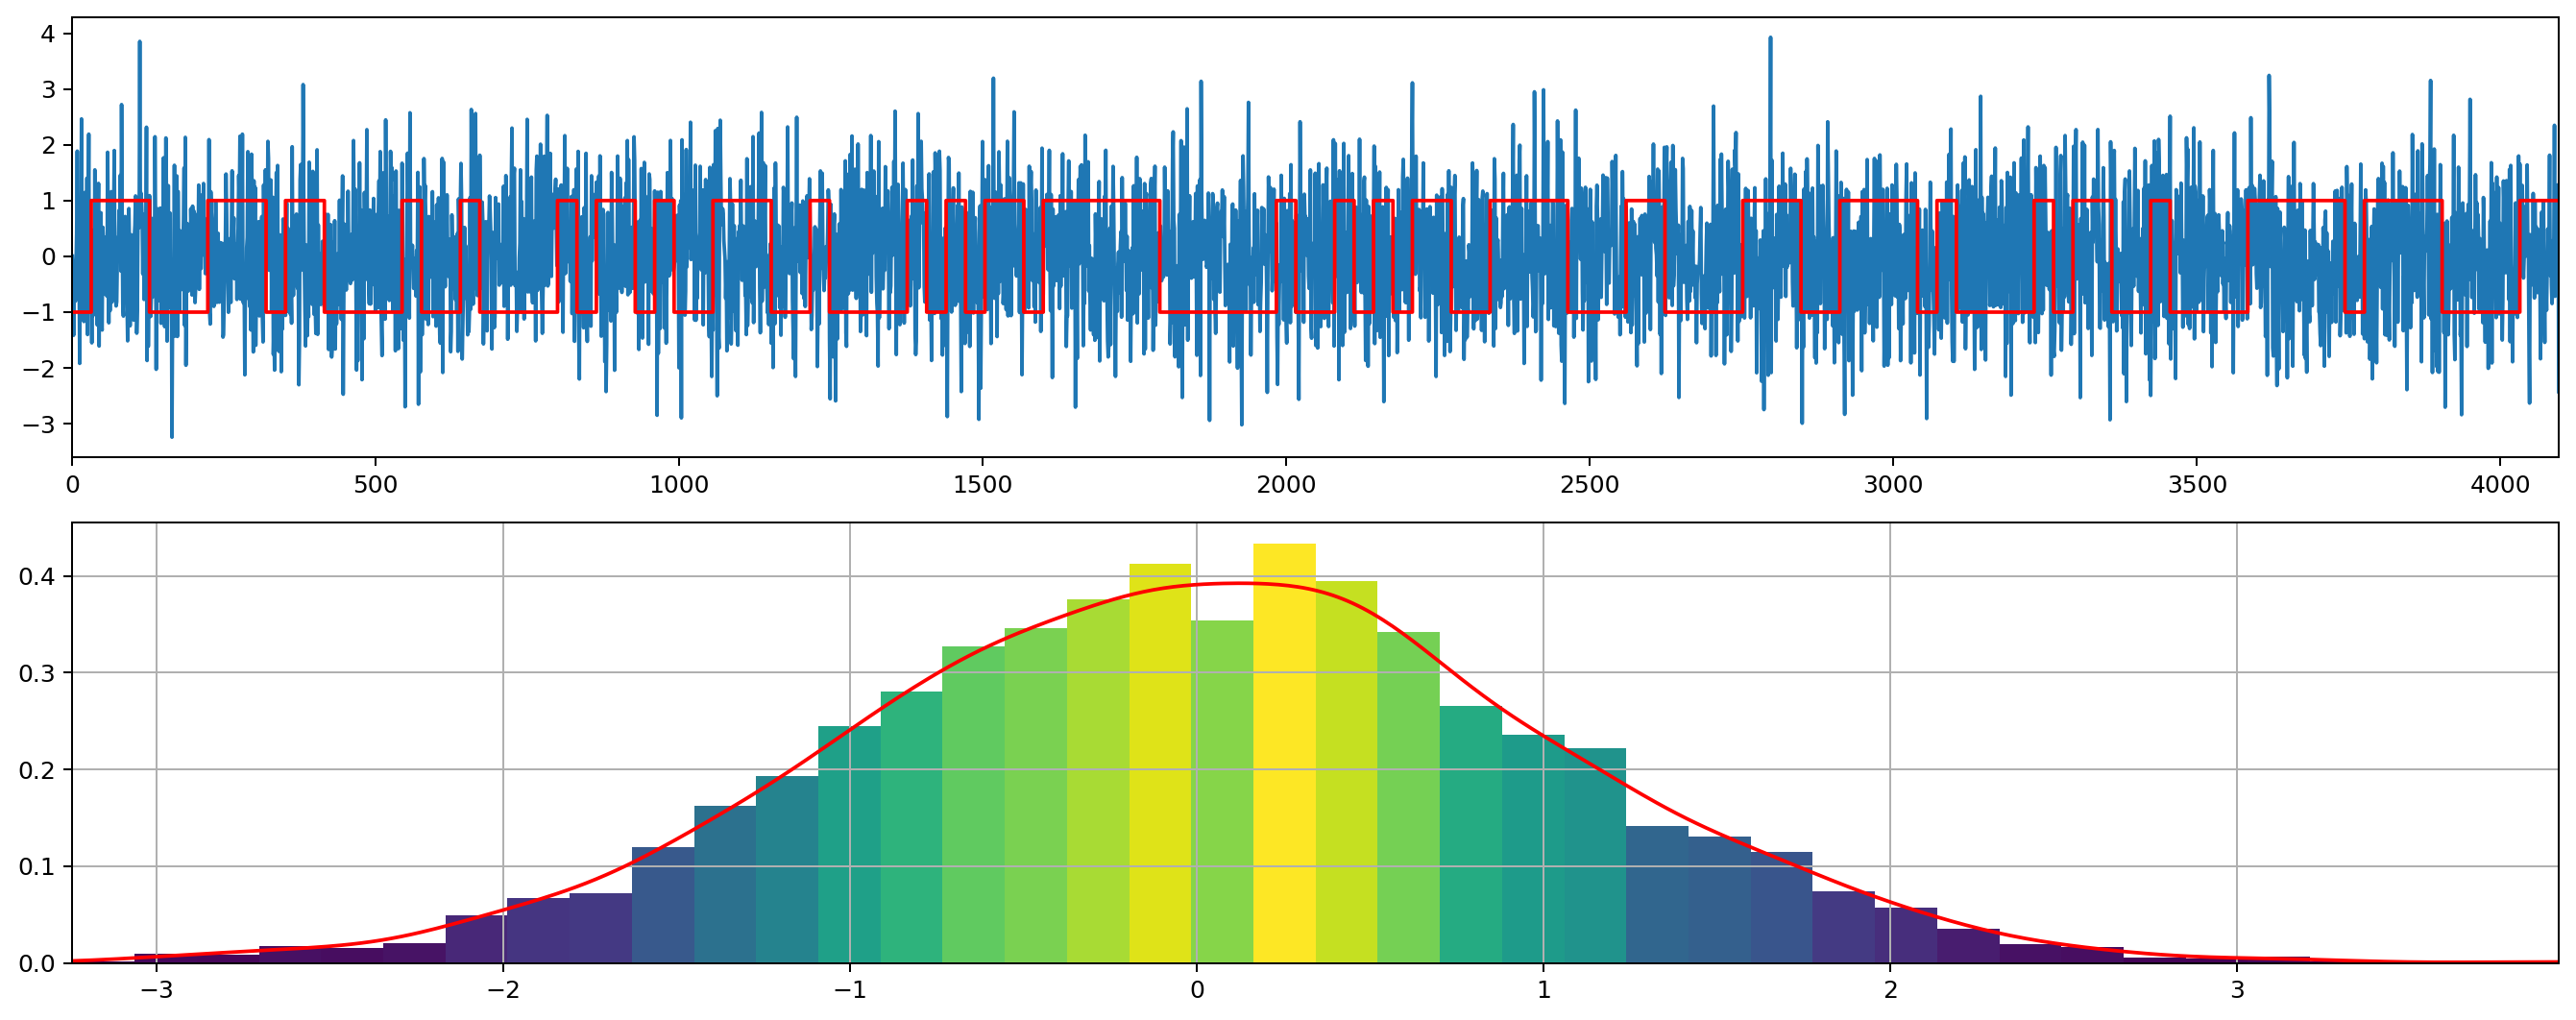

In [8]:
time = np.linspace(0,N,N)
Nbins = int(1 + 3.322*np.log2(len(signal)))
weight = np.ones_like(signal)/N

fig, ax = plt.subplots(2, 1, tight_layout=True)

# Zero-mean Gaussian noise
noise_variance = 1 # Noise variance
noise = np.random.normal(0, np.sqrt(noise_variance), N)
# kde = scipy.stats.gaussian_kde(noise, bw_method=0.25)
eval_points = np.linspace(np.min(noise), np.max(noise))
eval_points, y_sp = kde_function(noise)

ax[0].plot(time,noise)
ax[1].plot(eval_points, y_sp,"-r")
coloredhist(noise,plot=1)

ax[0].step(time,signal, '-r')
ax[0].set_xlim(0,len(signal))
ax[1].set_xlim(np.min(noise), np.max(noise))

In [9]:
def generatePDF(data):
  """
  Generates a PDF based in a sample of points over a domain
  Input:
    - data: vector of the data distribution

  Output:
    - the pdf of the input vector
  """
  return scipy.stats.gaussian_kde(data,bw_method=0.25).pdf

Optimal bandwidth: 0.15
Optimal bandwidth: 0.15


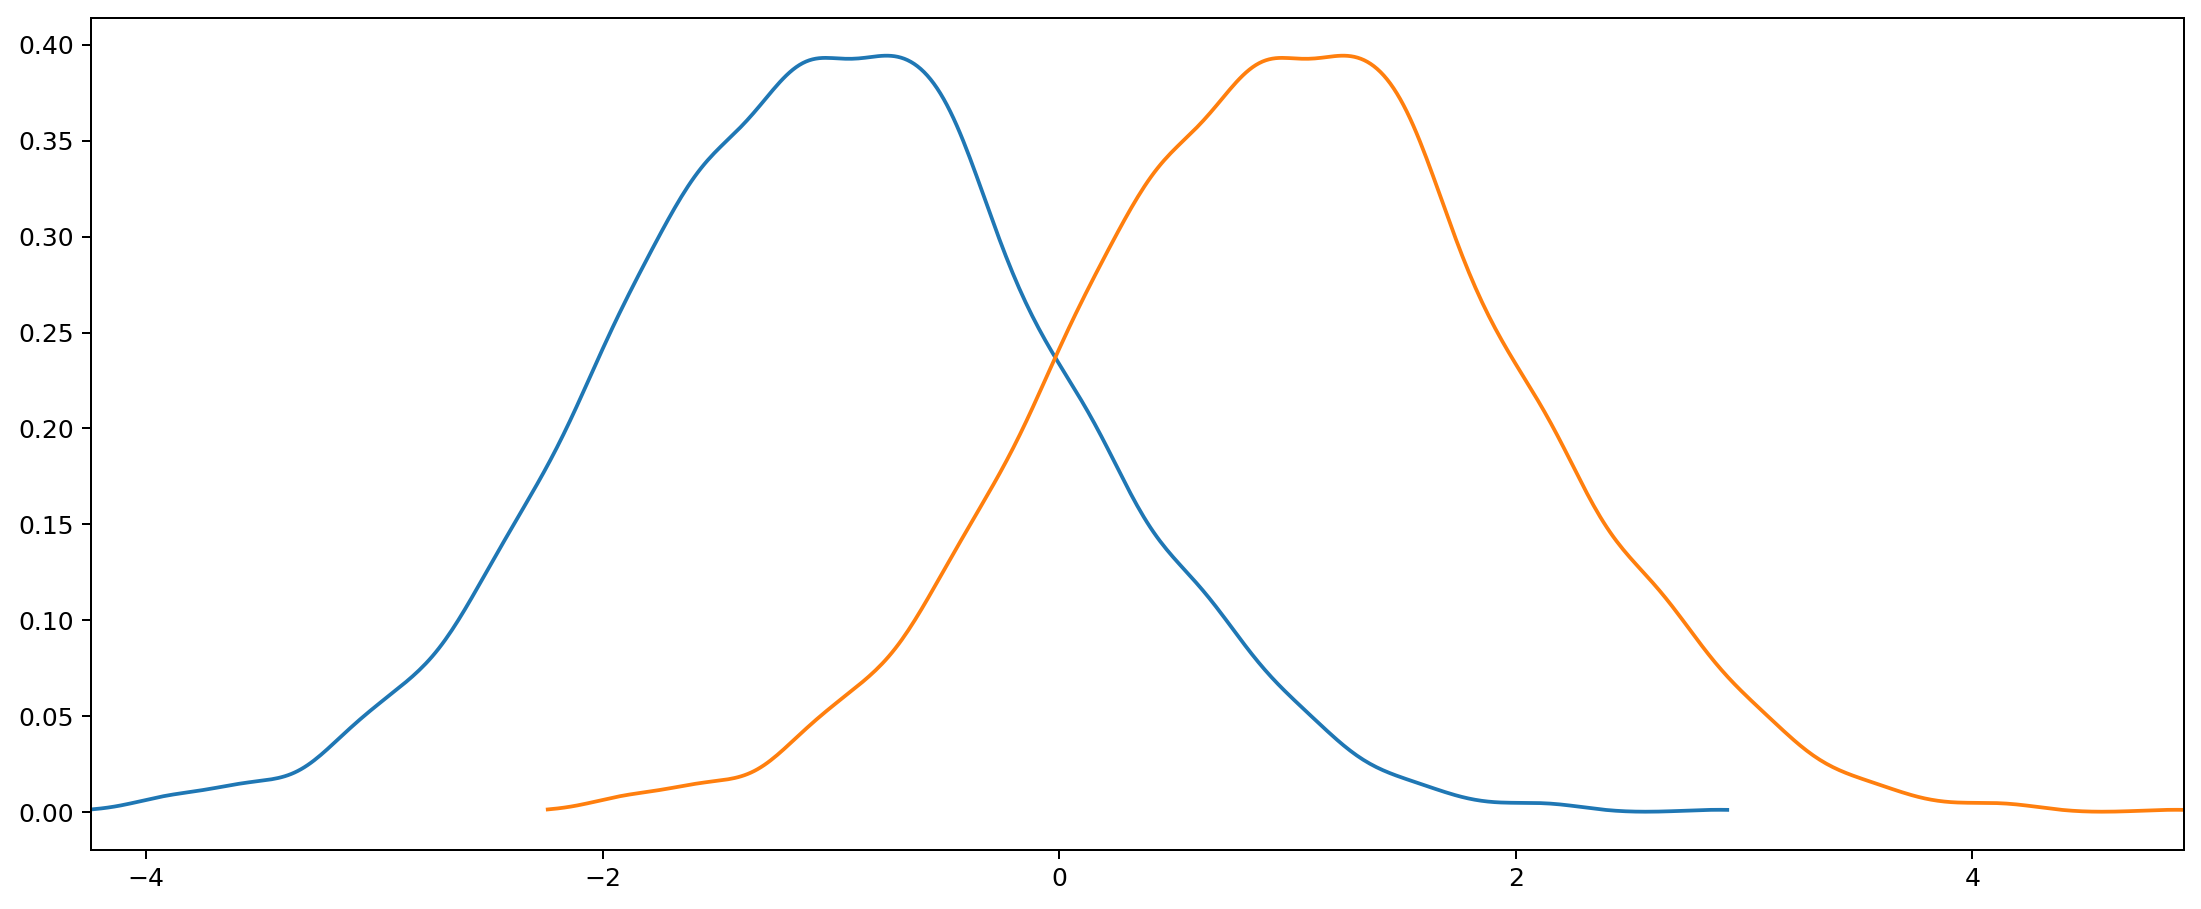

In [10]:
# Each symbol sample data
S0 = symbol_values[0] + noise
S1 = symbol_values[1] + noise

# PDF with KDE
eval0, pdf_0 = kde_function(S0)
pdf_1 = generatePDF(S1)

# Generate possible values to plot
n = 1000
x_min = min(np.min(S0),np.min(S1))
x_max = max(np.max(S0),np.max(S1))
X = np.linspace(x_min,x_max,n)

plt.plot(*kde_function(S0, method='Cross Validation'))
plt.plot(*kde_function(S1, method='Cross Validation'))
plt.xlim(min(X),max(X))
plt.show()

Additive Gaussian Channel
$y(t) = \sum_{\forall k}{{a}_n}\operatorname{rect}_{\delta t}(t-k\delta t) +\eta(t)$

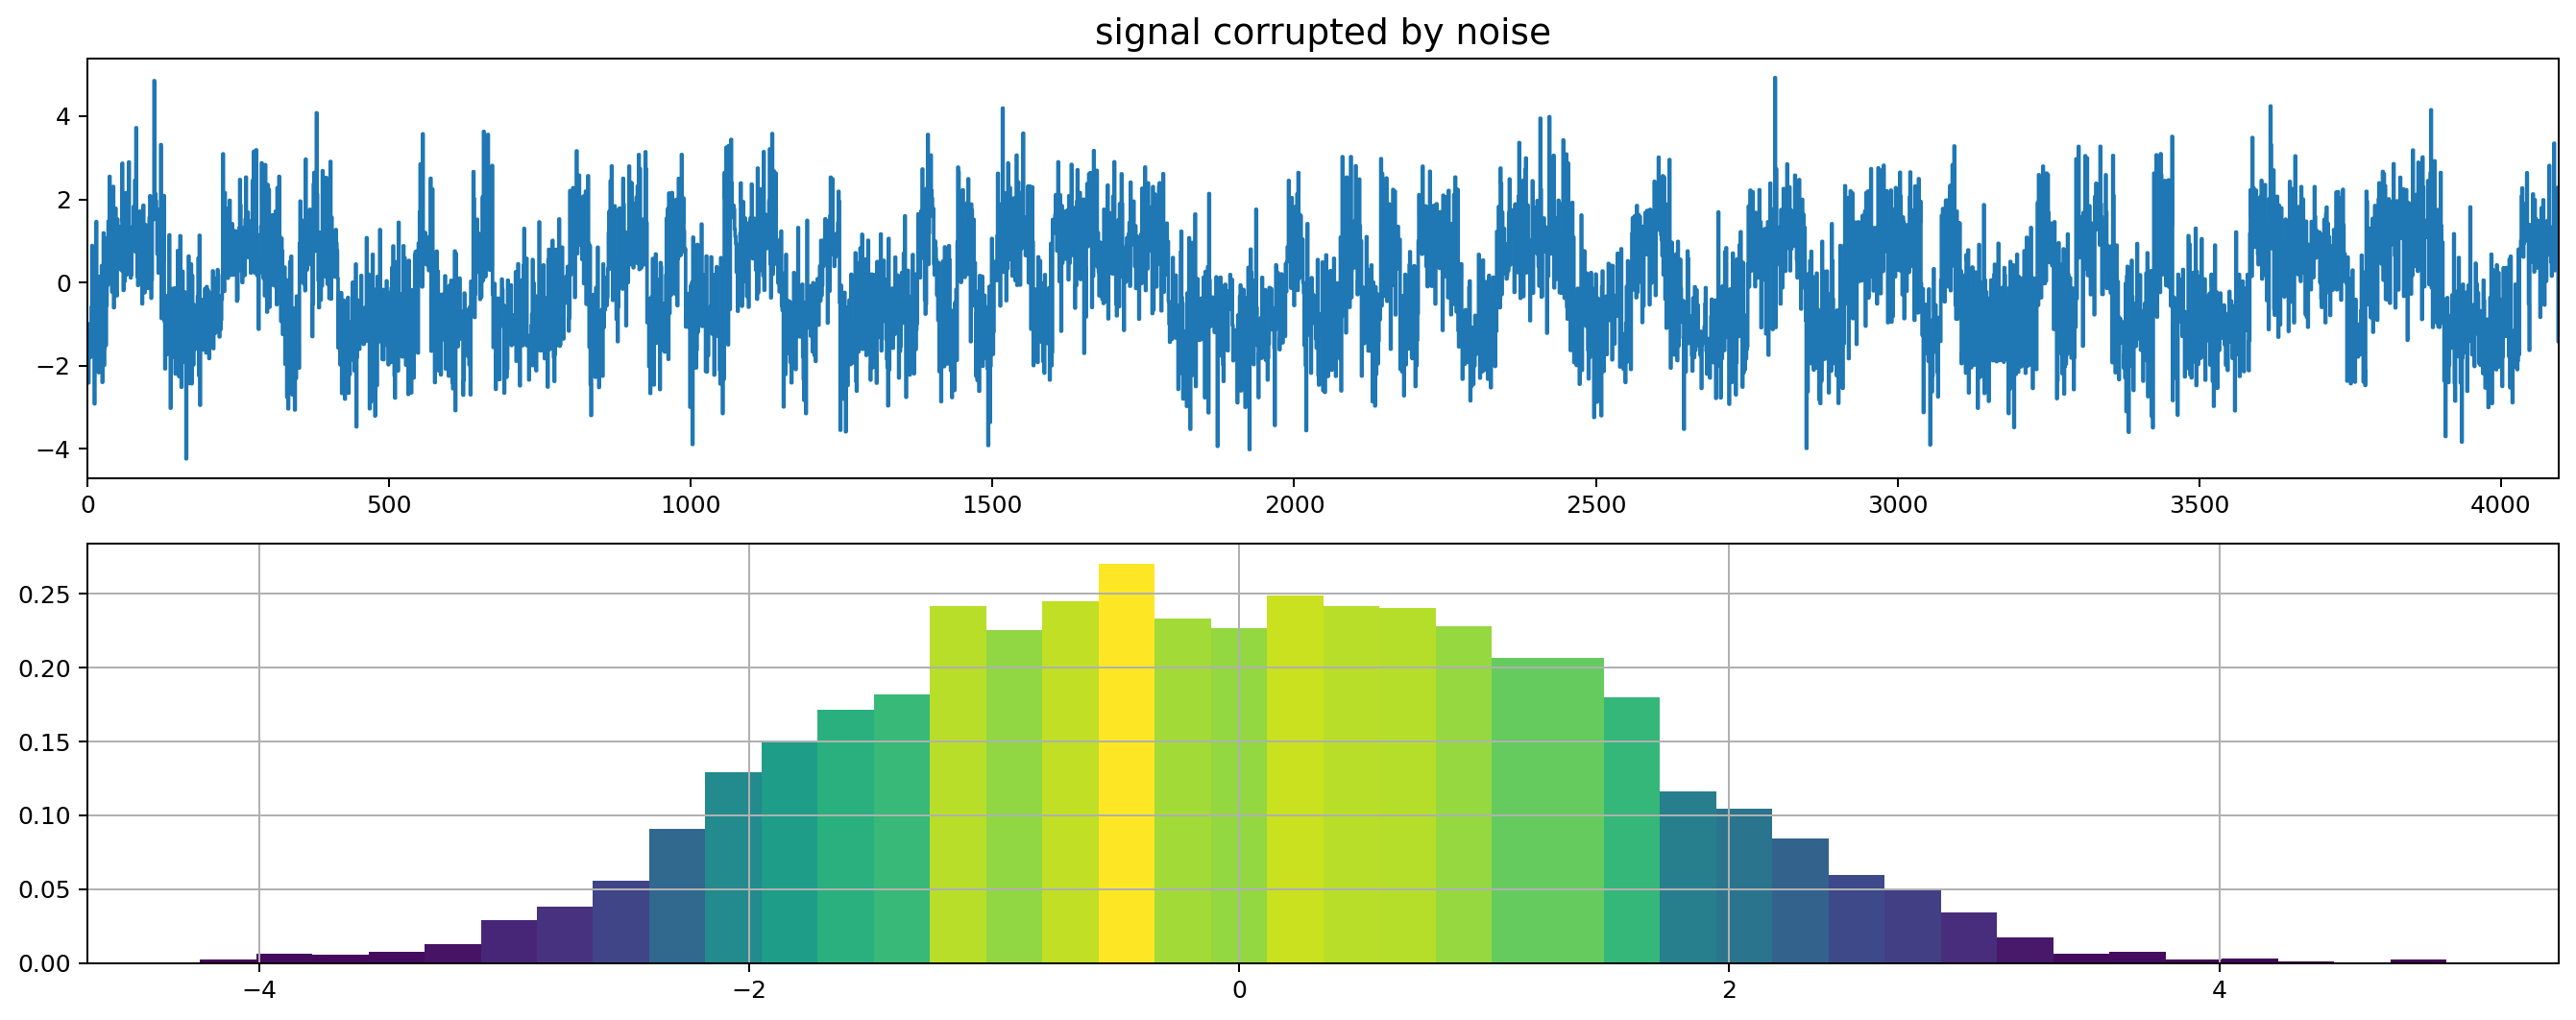

In [11]:
# Generate signal corrupted by noise
y = signal + noise
y_sygnal = y.copy()


fig, ax = plt.subplots(2, 1, tight_layout=True)
ax[0].step(time,y, '-')
ax[0].set_title('signal corrupted by noise')
ax[0].set_xlim(0,N)
coloredhist(y,plot=1)

plt.show()

$\varLambda (y)=  {{p(y|a_1 )}}/{{p(y|a_0 )}} \textrm{   Likelihood ratio}$

In [12]:
# The function "quad" has a critical impact on the performance of the algorithm
# So, we're going to create a faster, less precise integration algorithm
def integrate(fn,xmin,xmax,n):
  """
  Approximates the definite integral of a function within a specified range.

  Parameters:
  - fn: Function to integrate.
  - xmin: Lower bound of integration.
  - xmax: Upper bound of integration.
  - n: Number of subdivisions for the numerical integration.

  Returns:
  - Approximated definite integral value.
  """
  assert xmax > xmin
  x = np.linspace(xmin,xmax,n)
  y = fn(x)
  dx = (xmax - xmin)/n
  return np.sum(y)*dx
# This reduces the time from 1m 45s up to 50s with n = 100

# An even better approach is to precompute both functions and vary the umbral value
# All using numpy to get a better performance

# Generate all possible values with high detail
n = 1000
x_min = min(np.min(S0),np.min(S1))
x_max = max(np.max(S0),np.max(S1))
X = np.linspace(x_min,x_max,n)

x_0, y_0 = kde_function(S0, X, method="Cross Validation")
x_1, y_1 = kde_function(S1, X, method="Cross Validation")

Optimal bandwidth: 0.15
Optimal bandwidth: 0.15


In [13]:
# Declare a resolution
res = 1000
step = int(n/res)
x = np.linspace(x_min,x_max,res)

error = np.zeros(res)

#Get the error for each point in 'x'
for i in range(res):
  error[i] = symbol_probabilities[0]*np.sum(y_1[0:(i*step)]) +symbol_probabilities[1]*np.sum(y_0[(i*step):-1])
#Normalize the error array by the range (x_max - x_min)
error *= (x_max-x_min)/n

Threshold computation

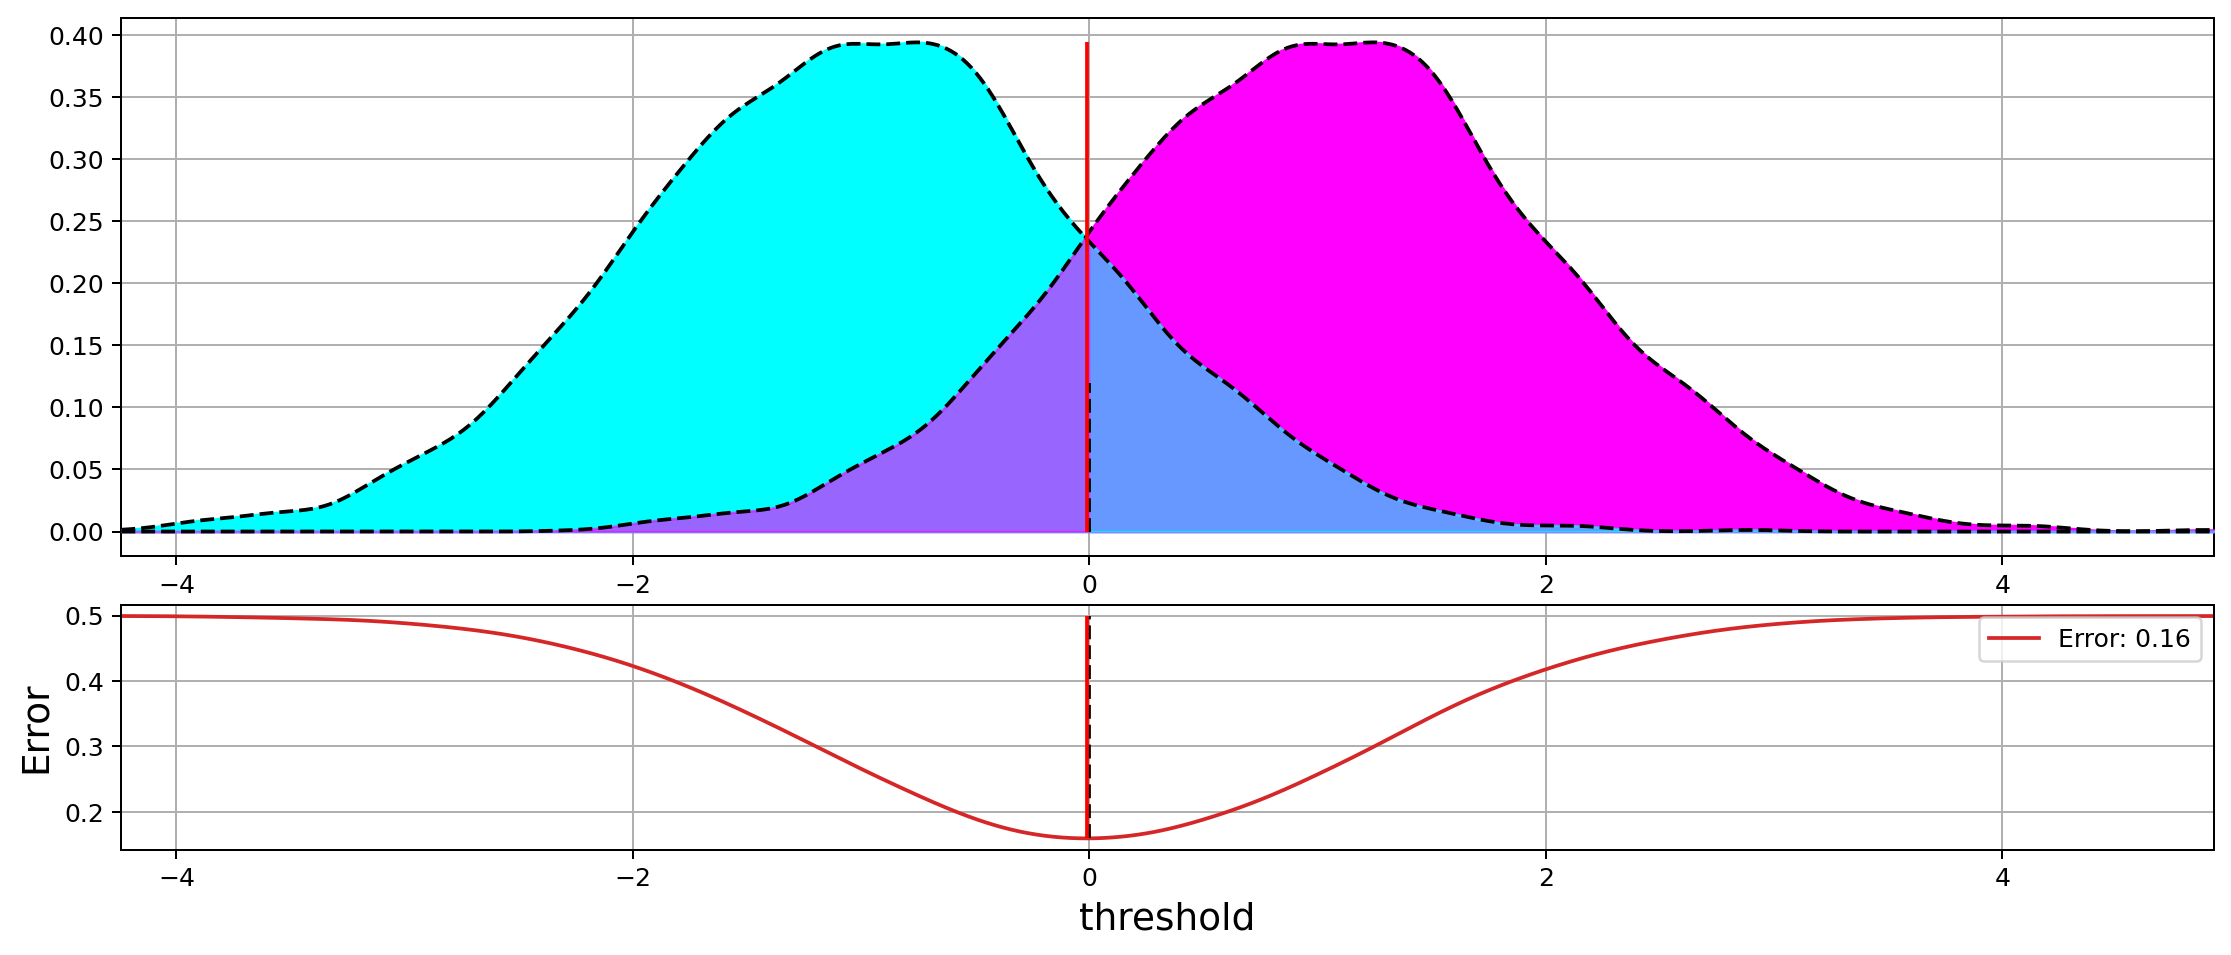

interactive(children=(FloatSlider(value=0.0, description='u', max=4.926237706436327, min=-4.241267340069072, s…

In [14]:
y0 = y_0
y1 = y_1
x = X
dx = (x_max-x_min)/res
print(x.size,y0.size,y1.size)

@interact(u=(x_min, x_max, dx))
def umbral_interact(u=0):
    """
    Visualizes the effect of an interactive threshold on two probability distributions.
    Parameters:
    - u: Value of the interactive threshold.
    Returns:
    - None
    """
    plt.figure()
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    plt.grid(True)

    plt.fill_between(x, y1, where=(x>=u-dx), color='#F0F', zorder=90)
    plt.fill_between(x, y0, where=(x>=u-dx), color='#0FF', zorder=90,alpha=0.6)

    plt.fill_between(x, y0, where=(x<u), color='#0FF', zorder=90)
    plt.fill_between(x, y1, where=(x<u), color='#F0F', zorder=90,alpha=0.6)

    plt.plot(x, y1, linestyle='--', color='#000', zorder=99)
    plt.plot(x, y0, linestyle='--', color='#000', zorder=99)

    plt.vlines(u, 0, 0.12, color='k', linestyle='--', zorder=100)
    plt.vlines(x[error.argmin()], 0, max(np.max(y1),np.max(y0)), color='r', linestyle='-', zorder=100)
    plt.xlim(min(x),max(x))
    plt.ylabel('')

    ax2 = plt.subplot2grid((3, 1), (2, 0))
    plt.grid(True)

    error_ = np.array(error)
    error_value = error[(abs(x-u)).argmin()]

    plt.plot(x, error_, color='C3', label=f'Error: {error_value:0.2f}')
    plt.vlines(u, error_.min(), error_.max(), color='k', linestyle='--')
    plt.vlines(x[error.argmin()], error_.min(), error_.max(), color='r', linestyle='-', zorder=100)
    plt.legend()
    plt.xlim(min(x),max(x))
    plt.ylabel('Error')
    plt.xlabel('threshold')

In [15]:
def a_posteriori(x,y0,y1):

  """
   Determines the threshold value in the 'x' array where the change from 'y0' being greater than 'y1' to 'y1' being greater occurs.

    Returns:
    float: The value in 'x' where the transition from 'y0' > 'y1' to 'y1' >= 'y0' occur
  """
  umbral = np.diff(y0>y1)
  return x[umbral.argmax()+1]

def practico(x,y0,y1,res=100):
  """
  Function to find the element in x corresponding to the minimum cumulative error
    between y0 and y1.

    Parameters:
    x (array-like): An array or a sequence of values.
    y0 (array-like): An array representing a set of initial values.
    y1 (array-like): An array representing a set of final values.
    res (int, optional): Resolution, default is 100.

    Returns:
    The element in x corresponding to the minimum cumulative error.
  """
  assert y0.size == y1.size
  assert y0.size >= res
  # Declare a resolution
  step = int(y0.size/x.size)

  error = np.zeros(x.size)
  for i in range(x.size):
    error[i] = np.sum(y1[0:(i)]) + np.sum(y0[(i):-1])

  return x[error.argmin()]

def error_gauss(sigma,n=100):
  """
  Generates the two symbols a0, a1 over an aditive gaussian channel and calculates
  the error of the treshold.
  Input:
    - sigma: std of the gaussian distribution.
    - n: number of sample points
  returns: a measure of the error
  """
  noise = np.random.normal(0,sigma,n)

  S0 =  symbol_values[0] + noise
  S1 =  symbol_values[1] + noise

  x_min = min(np.min(S0),np.min(S1))
  x_max = max(np.max(S0),np.max(S1))
  x = np.linspace(x_min,x_max,n)
  x_0, y_0 = kde_function(S0, x, method="Cross Validation")
  x_1, y_1 = kde_function(S1, x, method="Cross Validation")

  plt.plot(x,y_0)
  plt.plot(x,y_1)
  plt.xlim(min(x),max(x))
  plt.axvline(symbol_values[0])
  plt.axvline(symbol_values[1])
  plt.axvline(a_posteriori(x,y_0,y_1))
  plt.axvline(practico(x,y_0,y_1),color='red',linestyle="--")
  # return  abs(a_posteriori(x,y0,y1)-practico(x,y0,y1))
  return  abs(practico(x,y_0,y_1))

Optimal bandwidth: 0.05
Optimal bandwidth: 0.05
0.0 %
Optimal bandwidth: 0.10
Optimal bandwidth: 0.10
0.1 %
Optimal bandwidth: 0.30
Optimal bandwidth: 0.30
0.2 %


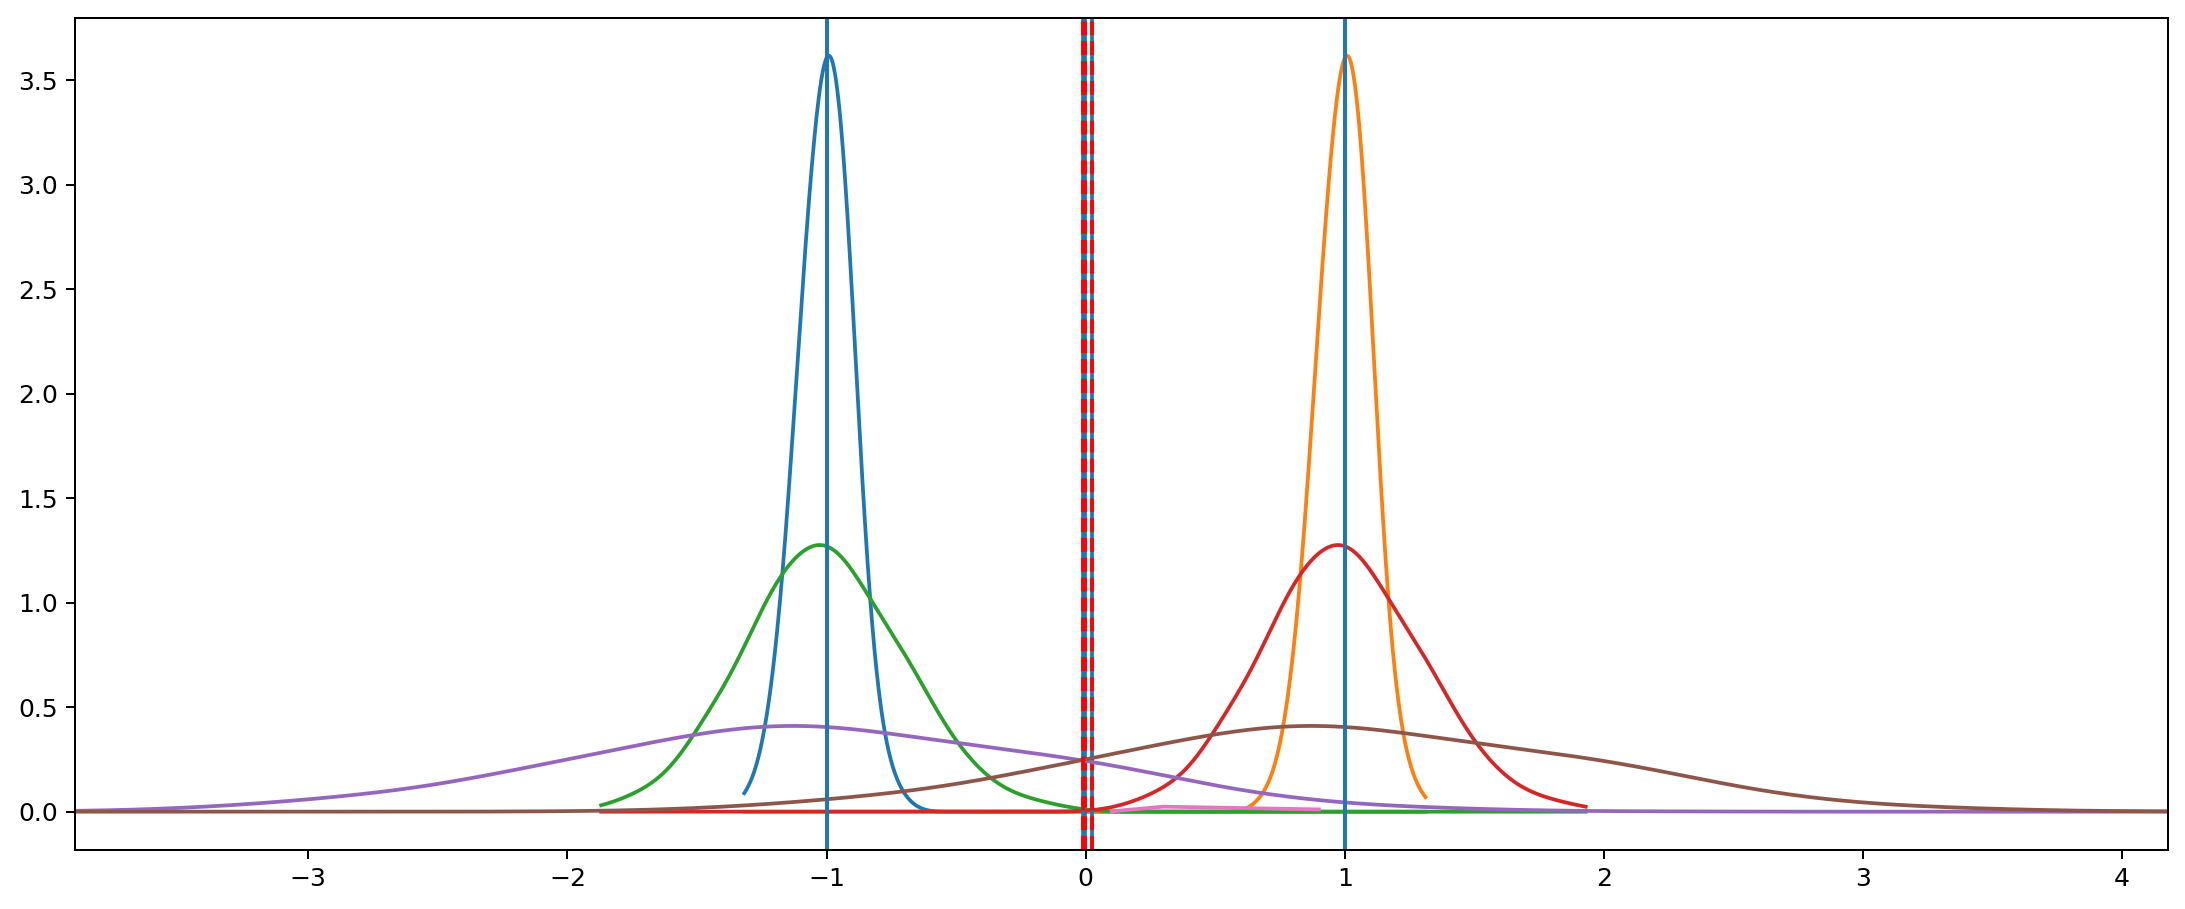

In [16]:
# Get the error for each std

sigmas = np.array([0.1,0.3,0.9])
errors = np.zeros(sigmas.size)
for i in range(errors.size):
  errors[i] = error_gauss(sigmas[i],1000)
  print(i/error.size*100,"%")

plt.plot(sigmas,errors)

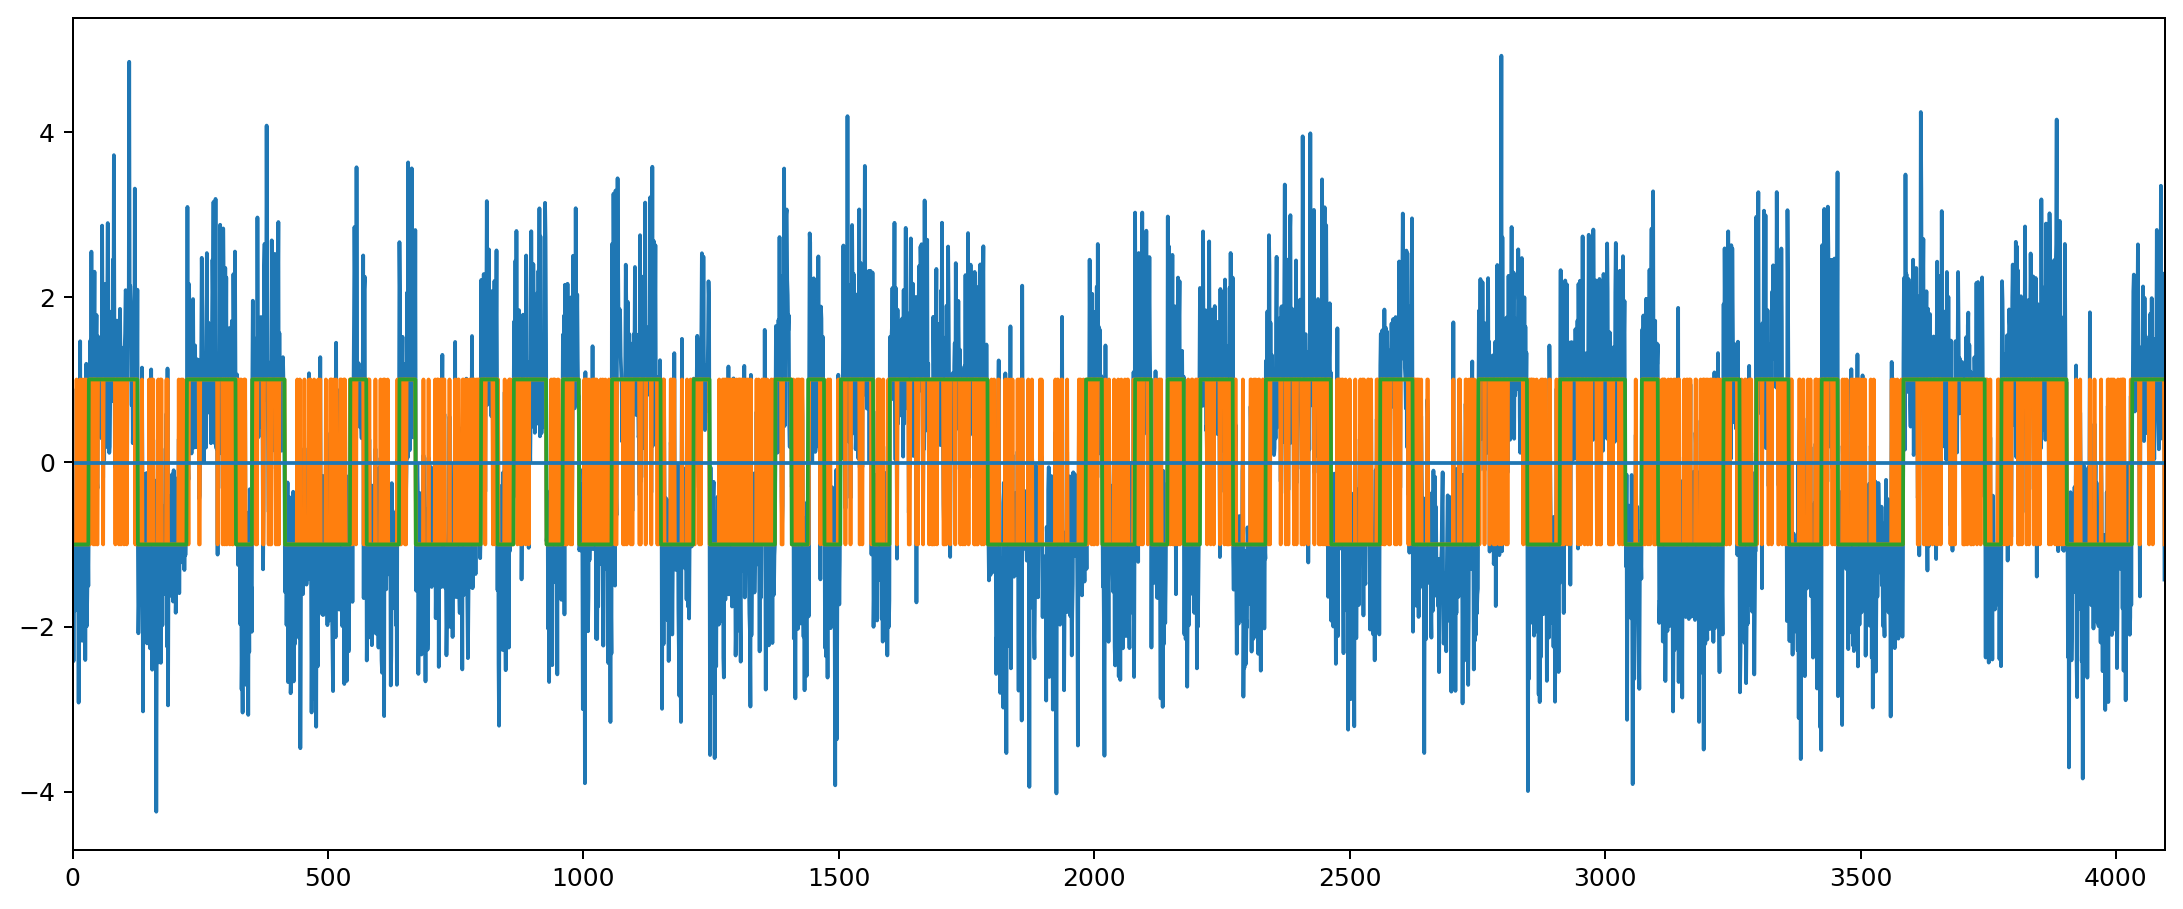

In [17]:
def estimate_symbols(x,threshold=0, a0=1, a1=-1):
  """
  Estimates symbols based on a given threshold.

  Parameters:
  - x: Input signal.
  - threshold: Threshold value for symbol estimation (default is 0).
  - a0: Symbol value for negative decisions (default is 1).
  - a1: Symbol value for positive decisions (default is -1).

  Returns:
  - Estimated symbols based on the threshold.
  """
  des = x>threshold
  return np.where(des==0,a1,a0)

threshold = x[error.argmin()]
sygnal = estimate_symbols(y_sygnal,threshold)
plt.plot(y_sygnal)
plt.plot(sygnal)
plt.plot(signal)
plt.xlim(0,N)
plt.axhline(threshold)

1000


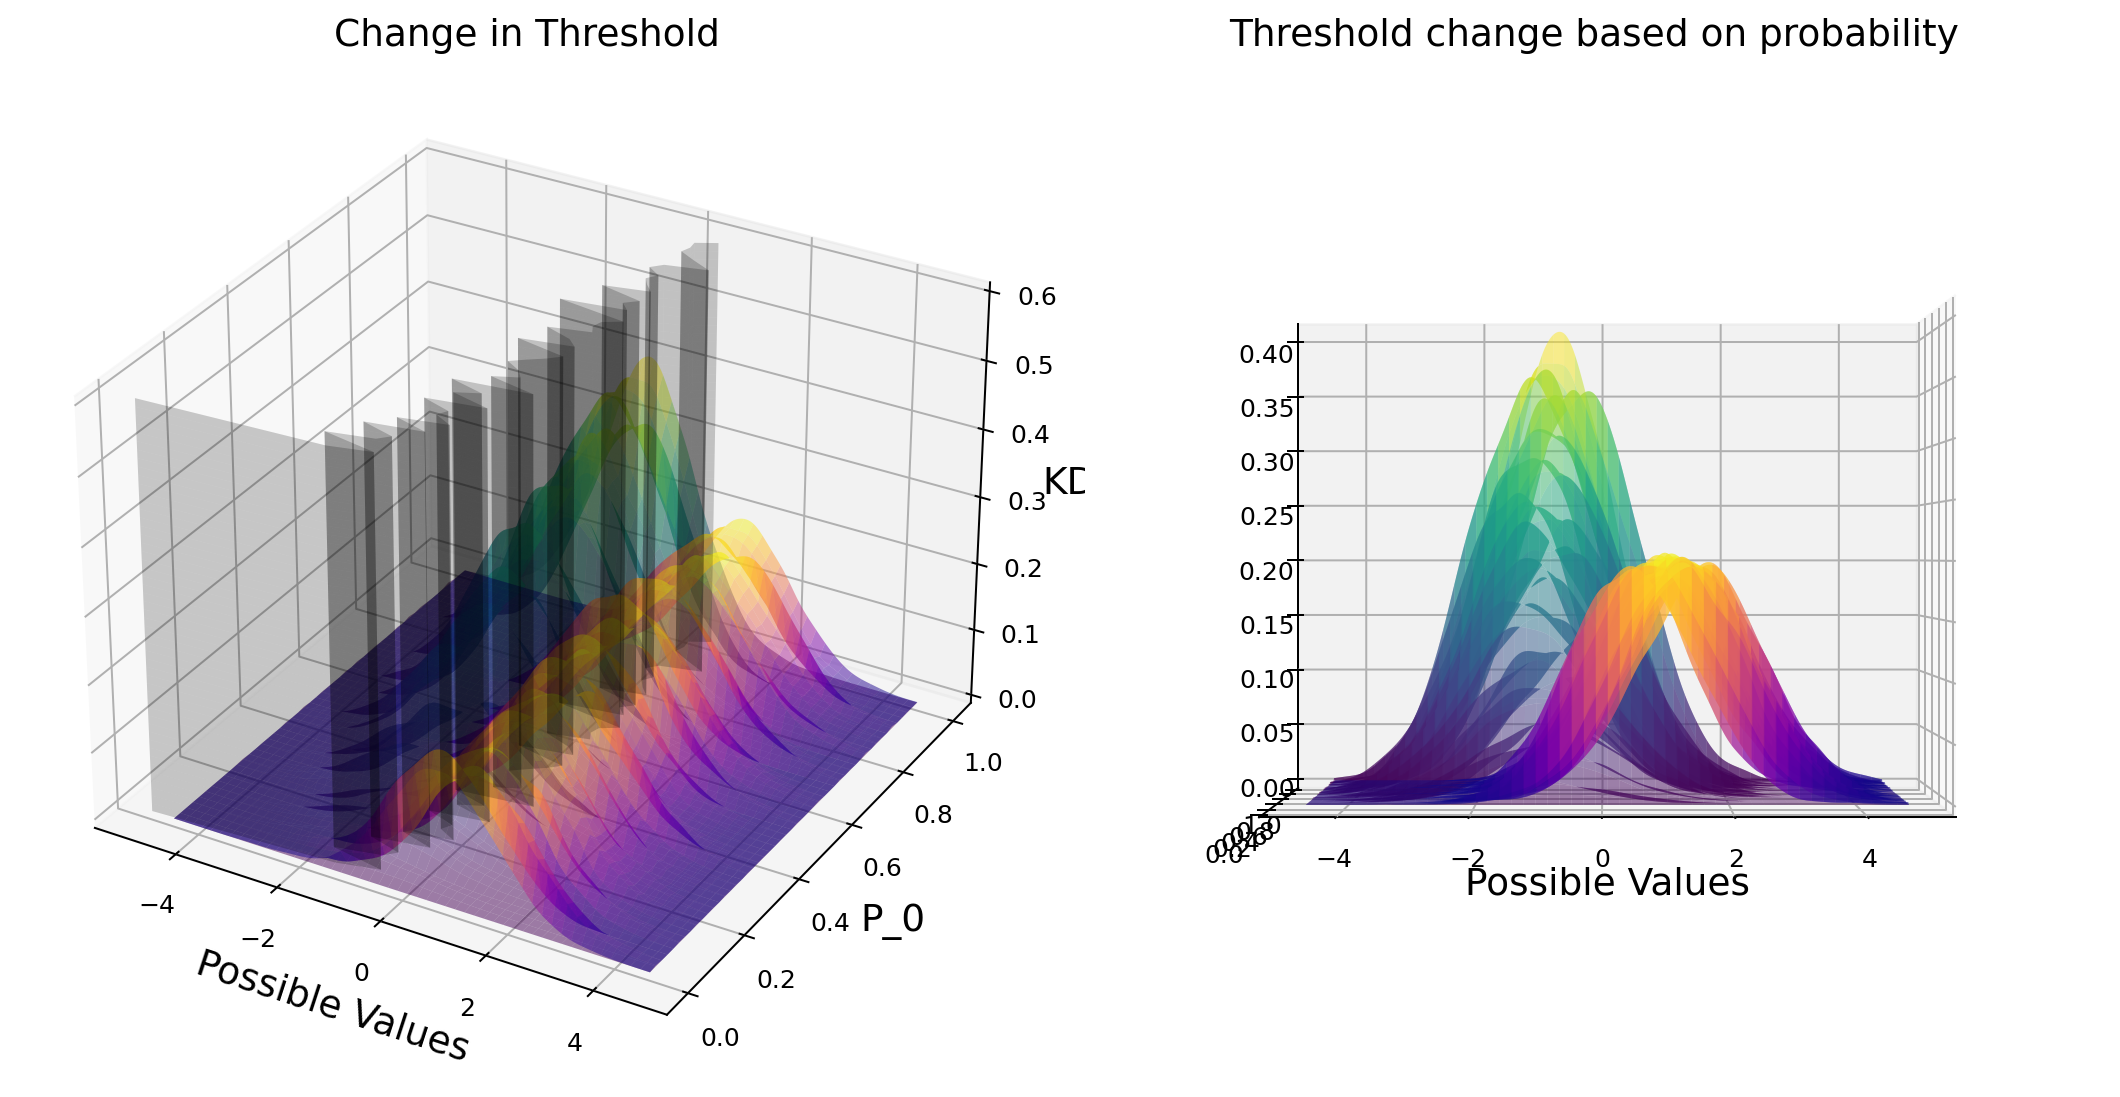

In [18]:
# Rango de valores de probabilidades
p_values = np.linspace(0, 1, 50)

print(x.size)
# Contenedor para los resultados
Z0 = np.zeros((len(p_values), len(x)))
Z1 = np.zeros((len(p_values), len(x)))
# Contenedor Umbral
U = np.zeros((len(p_values), len(x)))


# Iteramos cada una de las posibles probabilidades
for i, p in enumerate(p_values):

    # Calculamos la probabilidad del segundo simbolo
    p_1 = symbol_probabilities[1]
    #p_1 = 1 - p

    # Calculamos el ruido gaussiano para cada simbolo
    noise2 = np.random.normal(0, noise_variance, N)
    eval_points = np.linspace(np.min(noise2), np.max(noise2))

    S0 =  symbol_values[0] + noise2
    S1 =  symbol_values[1] + noise2

    # Calculamos kde para cada simbolo
    x_0, y_0 = kde_function(S0, x)
    x_1, y_1 = kde_function(S1, x)

    # Multiplicamos las probabilidades de cada simbolo
    py_0 = p * y_0
    py_1 = p_1 * y_1

    # Guardar los resultados
    Z0[i, :] = py_0
    Z1[i, :] = py_1

    # Calculo del umbral
    x_min = min(np.min(S0), np.min(S1))
    x_max = max(np.max(S0), np.max(S1))
    x = np.linspace(x_min, x_max, res)

    for l in range(res):
      error[l] = p_1*np.sum(y_1[0:(l*step)]) + p*np.sum(y_0[(l*step):-1])
    error *= (x_max-x_min)/n

    U[i, :] = x[error.argmin()]


# Creamos el grid para la grafica 3D
A, P = np.meshgrid(x, p_values)

fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Fijar altura de superficie del umbral
E = np.ones_like(A)
for n in range(E.shape[1]):
    E[:, n] = 1 - n/E.shape[1]

E *= 0.6

# Gráfico combinado
ax1.plot_surface(A, P, Z0, cmap='viridis', alpha=0.5)
ax1.plot_surface(A, P, Z1, cmap='plasma', alpha=0.5)
ax1.plot_surface(U, P, E, color='black', alpha=0.2)
ax1.set_xlabel('Possible Values')
ax1.set_ylabel('P_0')
ax1.set_zlabel('KDE')
ax1.set_title('Change in Threshold')


ax2.plot_surface(A, P, Z0, cmap='viridis', alpha=0.5)
ax2.plot_surface(A, P, Z1, cmap='plasma', alpha=0.5)
ax2.set_xlabel('Possible Values')
ax2.set_title('Front View')

ax2.view_init(elev=0, azim=-90)

# Mostrar los gráficos
plt.title('Threshold change based on probability')
plt.tight_layout()
plt.show()

grafica $3D$ de error que visualiza como varia la tasa de error en función de dos parámetros: SNR(Relación Señal Ruido) "eje X",
el umbral de decisión "eje Y", mientras que el  "eje Z"
 permite calcular la tasa de error para cada combinación de SNR y umbral de decisión.

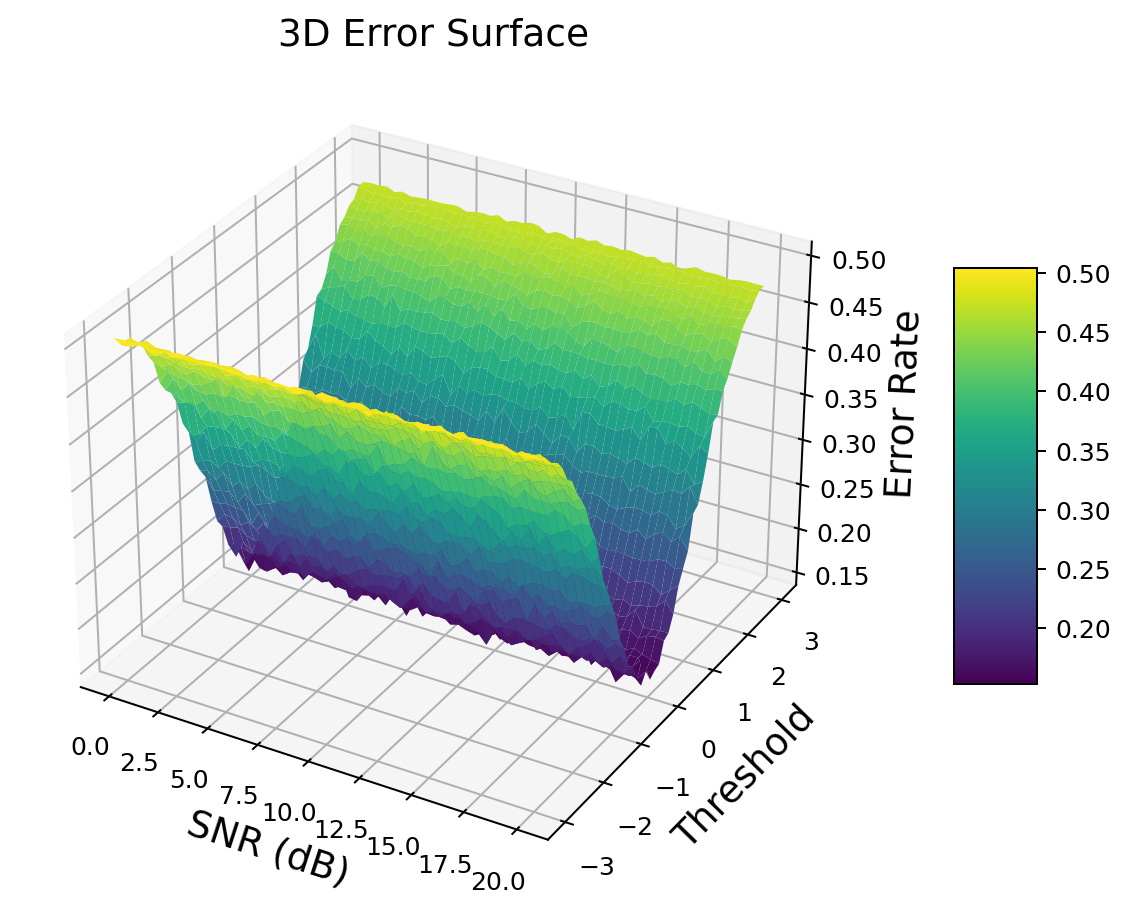

In [19]:
def calculate_error(snr, threshold):
    """
    Calculate error rate based on SNR (Signal-to-Noise Ratio) and threshold.

    Parameters:
    - snr: Signal-to-Noise Ratio in decibels.
    - threshold: Decision threshold for symbol estimation.

    Returns:
    - Error rate calculated for the given SNR and threshold.
    """
    snr_linear = 10 ** (snr / 10)
    Noise_variance = 1 / snr_linear
    Noise = np.random.normal(0, np.sqrt(noise_variance), N)
    noisy_signal = signal + Noise

    estimated_symbols = np.where(noisy_signal > threshold, symbol_values[1], symbol_values[0])
    num_errors = np.sum(estimated_symbols != signal)

    return num_errors / N

snr_values = np.linspace(0, 20, 50)
threshold_values = np.linspace(-3, 3, 50)

errors = np.zeros((len(snr_values), len(threshold_values)))

# Iteramos sobre cada valor de SNR y umbral utilizando dos bucles anidados.
for i, snr in enumerate(snr_values):
    for j, threshold in enumerate(threshold_values):
        errors[i, j] = calculate_error(snr, threshold)

SNR, Thresholds = np.meshgrid(snr_values, threshold_values)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(SNR, Thresholds, errors.T, cmap='viridis', edgecolor='none')

ax.set_xlabel('SNR (dB)')
ax.set_ylabel('Threshold')
ax.set_zlabel('Error Rate')
ax.set_title('3D Error Surface')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [20]:
def estimate_error(original,estimated):
  """
  Function to estimate the error rate between two arrays.

    Parameters:
    original (array-like): The original array of values.
    estimated (array-like): The estimated or compared array of values.

    Returns:
    float: The ratio of the total number of errors to the size of the array.
  """
  error = original!=estimated
  total_error = error.sum()
  return total_error/error.size

error_final = estimate_error(signal, sygnal)
print("Error por sample: ",error_final)


Error por sample:  0.158203125


In [21]:
def detect_euclidean_distance(data,a0,a1):
  """
    Function to detect the closest symbol (a0 or a1) to the given data point using Euclidean distance.

    Parameters:
    data : The data point or array of data points for which the distance is to be calculated.
    a0 : The first symbol.
    a1 : The second symbol.

    Returns:
    int: The index of the closest symbol.
    """
  distances = np.array([data-a0,data-a1])
  distances = distances**2
  distances =np.sum(distances,axis=1)
  return int(np.argmin(distances))

(0.0, 4096.0)

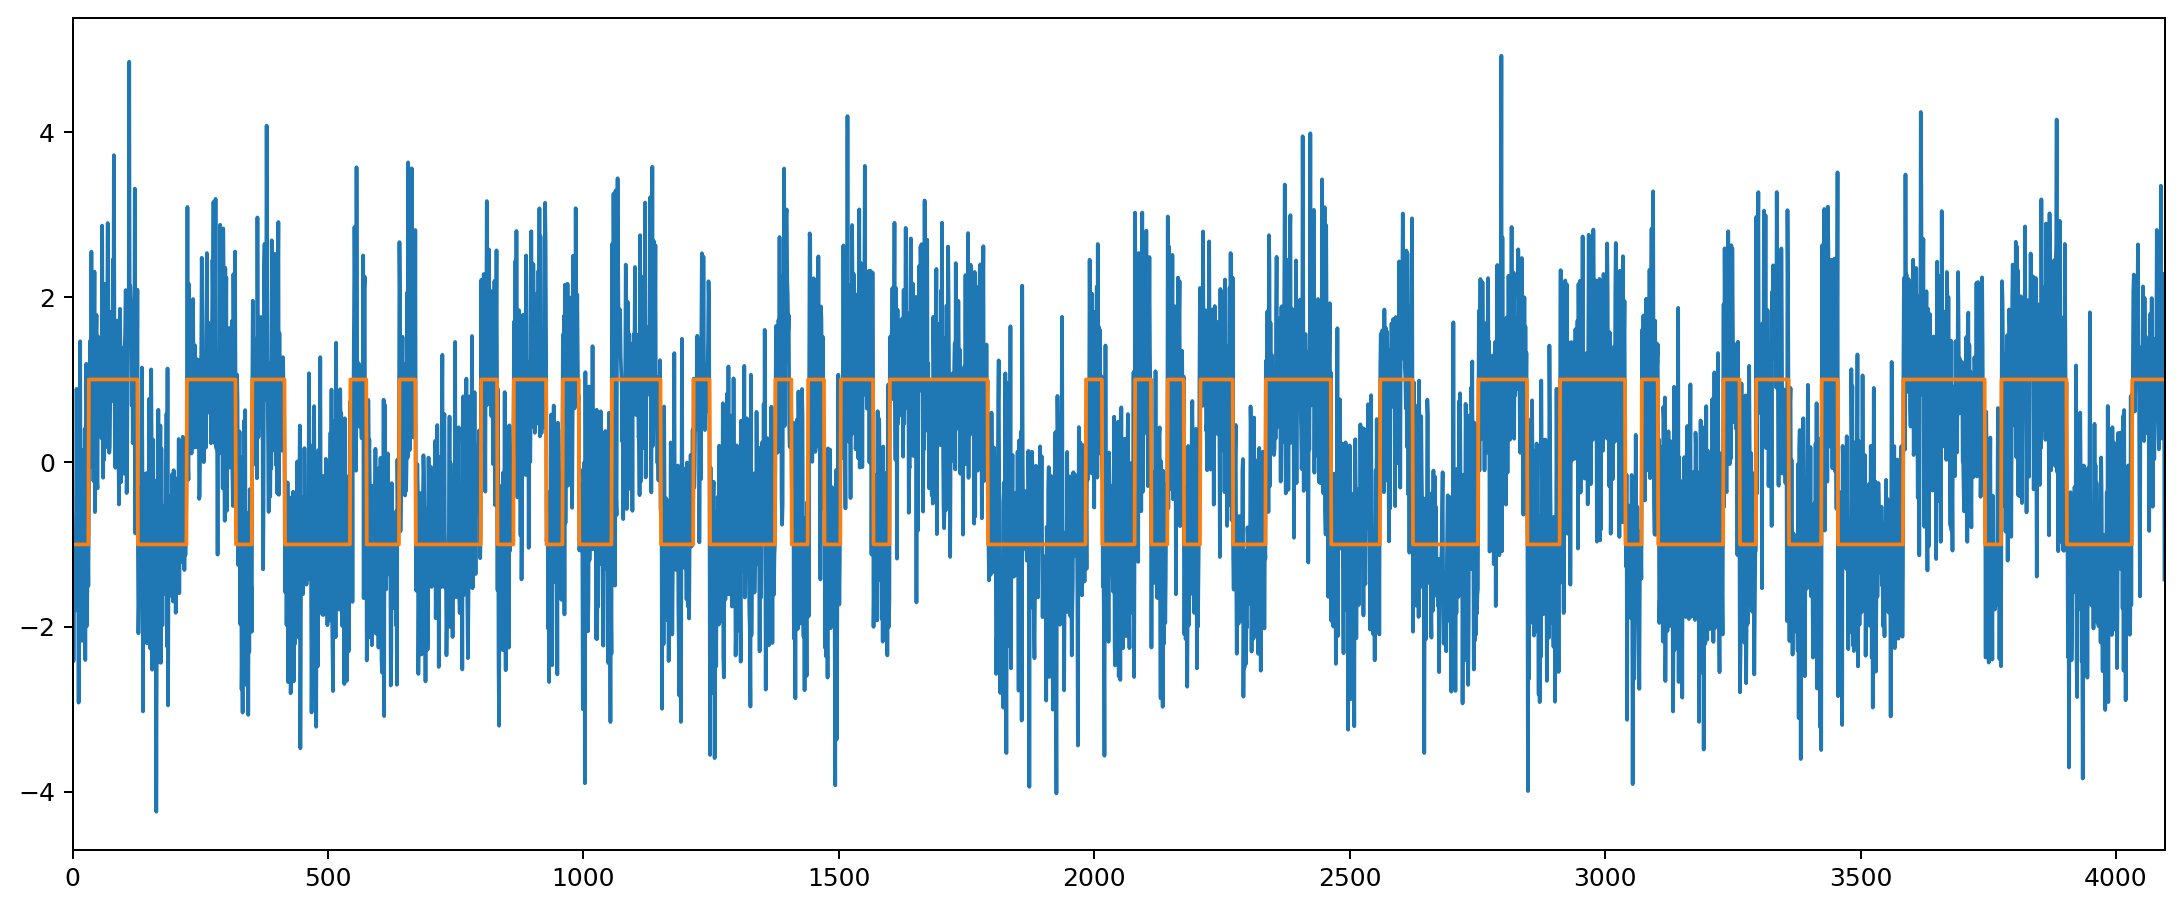

In [22]:
N_samples = Nsamples_por_symbol
N_symbols = Nsymbols
t = np.linspace(0,2*np.pi,N_samples)
a0 = np.array([-1]*N_samples)
a1 = np.array([1]*N_samples)

an = [a0,a1]

# Plot the original sygnal and the one with the noise
plt.plot(y_sygnal)
plt.plot(signal)
plt.xlim(0,N)

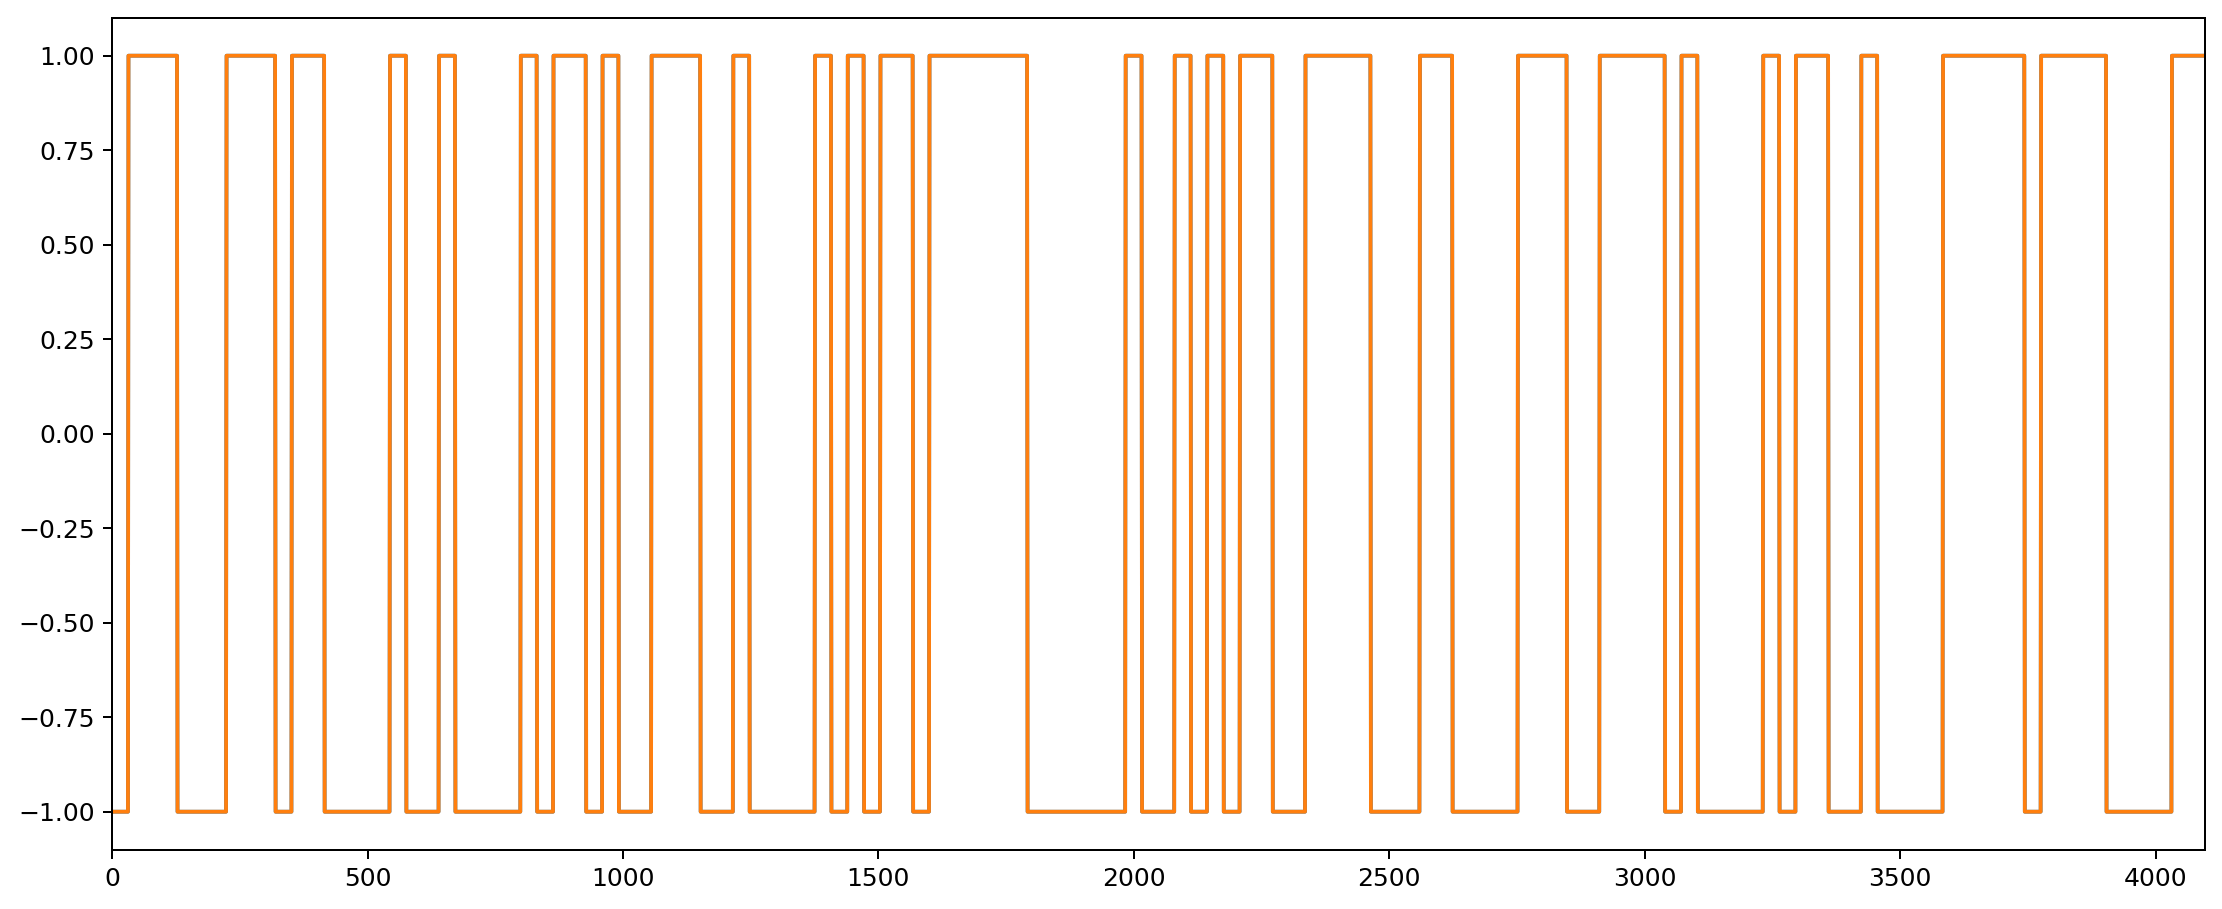

Euclidean distance error 0.0


In [23]:
# Predict based on the euclidean distance
prediction_indices = np.zeros(N_symbols)
for i in range(N_symbols):
  prediction_indices[i] = detect_euclidean_distance(y_sygnal[i*N_samples:(i+1)*N_samples],a0,a1)

prediction = np.zeros((N_symbols,N_samples))

for i,index in enumerate(prediction_indices):
  prediction[i] = an[int(index)]

prediction = np.concatenate(prediction)
plt.plot(signal)
plt.plot(prediction)
plt.xlim(0,N)
plt.show()
print("Euclidean distance error",estimate_error(prediction,signal))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=83ce4cb7-8e4d-450b-9ed2-4670860e2d8a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>